In [110]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet101, ResNet50, VGG16, VGG19, InceptionV3, InceptionResNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inception_resnet_preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.auto import trange, tqdm
from keras.utils import to_categorical

In [123]:
def create_dataset(img_folder):
   
    train_data=[]
    val_data=[]
    test_data=[]
    
    train_label=[]
    val_label=[]
    test_label=[]
   
    for dir1 in tqdm(os.listdir(img_folder)):
        for eye in os.listdir(os.path.join(img_folder, dir1)):
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in [1, 3, 5, 6, 7, 9]):
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                train_data.append(img)
                train_label.append(dir1+'0' if eye == 'L' else dir1+'1')
                
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in [0, 2, 8]):
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                val_data.append(img)
                val_label.append(dir1+'0' if eye == 'L' else dir1+'1')
                
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in [4, 8]):
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                test_data.append(img)
                test_label.append(dir1+'0' if eye == 'L' else dir1+'1')
                
    return np.array(train_data), np.array(train_label), np.array(val_data), np.array(val_label), np.array(test_data), np.array(test_label)

In [124]:
X_train, y_train, X_val, y_val, X_test, y_test = create_dataset('CASIA-Iris-Thousand')

  0%|          | 0/1000 [00:00<?, ?it/s]

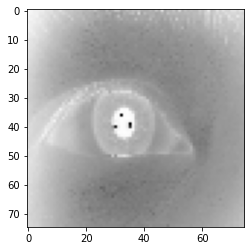

In [125]:
plt.imshow((X_train[0]*255).astype(np.uint8))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(np.concatenate((X_train, X_val, X_test), axis=0), np.concatenate((y_train, y_val, y_test), axis=0), test_size=0.2, random_state=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
np.save('temp_data/X_train.npy', X_train)
np.save('temp_data/X_val.npy', X_val)
np.save('temp_data/X_test.npy', X_test)

np.save('temp_data/y_train.npy', y_train)
np.save('temp_data/y_val.npy', y_val)
np.save('temp_data/y_test.npy', y_test)

In [ ]:
X_train = np.load('temp_data/X_train.npy')
X_val = np.load('temp_data/X_val.npy')
X_test = np.load('temp_data/X_test.npy')

y_train = np.load('temp_data/y_train.npy')
y_val = np.load('temp_data/y_val.npy')
y_test = np.load('temp_data/y_test.npy')

In [126]:
def combine_LR(X, y, classes, img_num):
    X_combined = []
    y_combined = []
    for i in range(0, classes*img_num*2, img_num*2):
        for j in range(img_num):
            X_combined.append(np.concatenate((X[i+j], X[i+j+img_num]), axis=1))
            y_combined.append(y[i])
    return np.array(X_combined), np.array(y_combined)

In [127]:
X_train, y_train = combine_LR(X_train, y_train, 1000, 6)
X_val, y_val = combine_LR(X_val, y_val, 1000, 3)
X_test, y_test = combine_LR(X_test, y_test, 1000, 2)

In [128]:
# X_train = resnet_preprocess_input(X_train)
# X_val = resnet_preprocess_input(X_val)
# X_test = resnet_preprocess_input(X_test)

X_train = vgg16_preprocess_input(X_train)
X_val = vgg16_preprocess_input(X_val)
X_test = vgg16_preprocess_input(X_test)

# X_train = inception_resnet_preprocess_input(X_train)
# X_val = inception_resnet_preprocess_input(X_val)
# X_test = inception_resnet_preprocess_input(X_test)

In [129]:
le = LabelEncoder()

y_train = to_categorical(le.fit_transform(y_train), num_classes=1000)
y_val = to_categorical(le.fit_transform(y_val), num_classes=1000)
y_test = to_categorical(le.fit_transform(y_test), num_classes=1000)

In [130]:
aug = ImageDataGenerator(
	zoom_range=0.05,
	height_shift_range=10,
	shear_range=0.15,
	rotation_range=10,
	fill_mode="nearest")

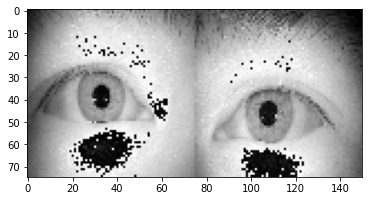

In [131]:
plt.imshow((X_train[0]*255).astype(np.uint8))

In [132]:
# Check if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [133]:
with tf.device('GPU:0'):
    # Load the ResNet101 model with pre-trained weights on ImageNet dataset
    model = VGG16(weights='imagenet', include_top=False, input_shape=(64,128,3))

    # Freeze the layers of the ResNet101 model
    for layer in model.layers:
        layer.trainable = False

    # Add custom layers on top of the ResNet101 model
    x = model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(1000, activation='softmax')(x)

    # Combine the ResNet101 model with the custom layers
    model = keras.models.Model(inputs=model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    # history = model.fit(aug.flow(X_train, y_train, batch_size=16), epochs=40, 
    #                     steps_per_epoch=len(X_train) // 16, 
    #                     validation_data=(X_val, y_val), verbose=1)
    history = model.fit(X_train, y_train, batch_size=16, epochs=40,
                        steps_per_epoch=len(X_train) // 16, 
                        validation_data=(X_val, y_val), verbose=1)

219055592/219055592 [==============================] - 33s 0us/step
Epoch 1/40
375/375 [==============================] - 29s 56ms/step - loss: 6.4619 - accuracy: 0.0213 - val_loss: 5.5541 - val_accuracy: 0.0597
Epoch 2/40
375/375 [==============================] - 16s 42ms/step - loss: 4.5688 - accuracy: 0.1452 - val_loss: 4.4142 - val_accuracy: 0.1673
Epoch 3/40
375/375 [==============================] - 18s 47ms/step - loss: 3.1571 - accuracy: 0.3345 - val_loss: 3.9533 - val_accuracy: 0.2267
Epoch 4/40
375/375 [==============================] - 18s 48ms/step - loss: 2.2355 - accuracy: 0.4890 - val_loss: 3.2187 - val_accuracy: 0.3573
Epoch 5/40
375/375 [==============================] - 16s 43ms/step - loss: 1.6521 - accuracy: 0.6127 - val_loss: 2.8982 - val_accuracy: 0.4077
Epoch 6/40
375/375 [==============================] - 17s 47ms/step - loss: 1.2728 - accuracy: 0.6828 - val_loss: 2.7932 - val_accuracy: 0.4300
Epoch 7/40
375/375 [==============================] - 18s 47ms/step 

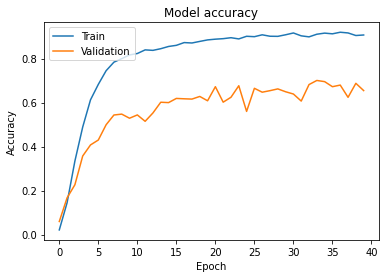

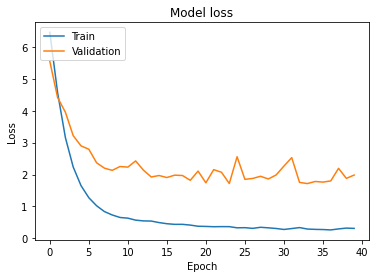

In [134]:
# Plot the training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [135]:
model.save('Model/INCRESV2_40.h5')

In [136]:
model = keras.models.load_model('Model/INCRESV2_40.h5')

63/63 [==============================] - 5s 36ms/step


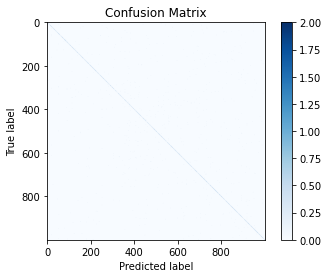

Accuracy: 68.10%


In [137]:
# Predict on the test data
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

# Plot the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy: {:.2f}%".format(accuracy * 100))


In [25]:
import sklearn.svm as svm
import sklearn.model_selection as model_selection

In [ ]:
X_train = np.load('temp_data/X_train.npy')
X_val = np.load('temp_data/X_val.npy')
X_test = np.load('temp_data/X_test.npy')

y_train = np.load('temp_data/y_train.npy')
y_val = np.load('temp_data/y_val.npy')
y_test = np.load('temp_data/y_test.npy')

In [22]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

In [23]:
with tf.device('GPU:0'):
    features_train = model.predict(X_train)
    features_val = model.predict(X_val)
    features_test = model.predict(X_test)

125/125 [==============================] - 2s 12ms/step


In [32]:
X_train = np.load('temp_data/X_train.npy')
X_val = np.load('temp_data/X_val.npy')
X_test = np.load('temp_data/X_test.npy')

y_train = np.load('temp_data/y_train.npy')
y_val = np.load('temp_data/y_val.npy')
y_test = np.load('temp_data/y_test.npy')

In [33]:
clf = svm.SVC(kernel='linear', C=1.0, probability=True)
clf.fit(features_train.reshape(features_train.shape[0], -1), y_train)

SVC(kernel='linear', probability=True)

In [37]:
predict = clf.predict(features_val.reshape(features_val.shape[0], -1))

In [38]:
accuracy = accuracy_score(predict, y_val)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 77.55%
